<a href="https://colab.research.google.com/github/seyong2/kaggle-digit-recognizer/blob/main/Digit_Recognizer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this notebook is to correctly identify digits in a dataset of tens of thousands of handwritten images published by the "Modified National Institute of Standards and Technology" (MNIST). This is done by building neural networks, a method of artificial intelligence that teaches computers to process data in a way inspired by the human brain. See [here]((https://www.kaggle.com/competitions/digit-recognizer/overview) for more details. 

Then let's get started by importing all the necessary libraries and data.

# 1. Import Python libraries and Data

In [1]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

import random
! pip install torchmetrics
import torch, torchmetrics
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 7.9 MB/s 


In [2]:
# Install the Kaggle library
! pip install kaggle

# Make a directory named ".kaggle"
! mkdir ~/.kaggle

# Copy the "kaggle.json" into this new directory
! cp kaggle.json ~/.kaggle/

# Allocate the required permission for this file
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c digit-recognizer

! unzip digit-recognizer.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 91% 14.0M/15.3M [00:00<00:00, 33.1MB/s]
100% 15.3M/15.3M [00:00<00:00, 38.9MB/s]
Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# 2. Load Training and Testing Data

In [3]:
# read 'train.csv' and 'test.csv' which are comma-separated values (csv) file into DataFrame.
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
print(f"The training data has {train_df.shape[0]} rows and {train_df.shape[1]} columns.")
print(f"The testing data has {test_df.shape[0]} rows and {test_df.shape[1]} columns.")

The training data has 42000 rows and 785 columns.
The testing data has 28000 rows and 784 columns.


In [5]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The training and test data contain 42,000 and 28,000 grayscale images of hand-drawn digits from 0 to 9, respectively.

The training data has 785 columns, one more column than the test data. The first column, `label`, represents the number written by the user.  

The images each have 784 pixels (28 pixels in height and 28 pixels in width), which corresponds to the number of remaining columns. Each pixel value ranges from 0 to 255, indicating the brightness of the corresponding pixel, and the higher the value, the darker it is.

Let's see how many images are in each class.

In [7]:
train_df['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

The images seem to be more or less evenly distributed across the digit classes. And since there are 10 different image classes (different types of numbers), it is a multi-class classification problem.

# 3. Transform Data and Prepare DataLoader

Before using the data in PyTorch, we need to turn them into tensors (multi-dimensional matrices containing elements of a single data type) and subsequently a Python iterable using `torch.utils.data.DataLoader`,


In [8]:
# convert dataframe to numpy array
train_arr = train_df.to_numpy()

# separate 'train_arr' into X (pixels) and y (label)
X = train_arr[:, 1:].reshape((train_df.shape[0], 28, 28, 1)).astype(np.uint8) # NCHW (Number of Images, Color Channels, Height, Width)
y = train_arr[:, 0]

According to [`ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor), a PIL Image or `numpy.ndarray` (H x W x C) in the range [0, 255] is converted to a `torch.FloatTensor` of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the `numpy.ndarray` has `np.uint8` as data type. That's why we converted `train_df` to a Numpy array with a new shape of (42000, 28, 28, 1) and data type of `np.unit8`.

In [9]:
# create 'data_transform' that converts X into tensors
data_transform = transforms.ToTensor()

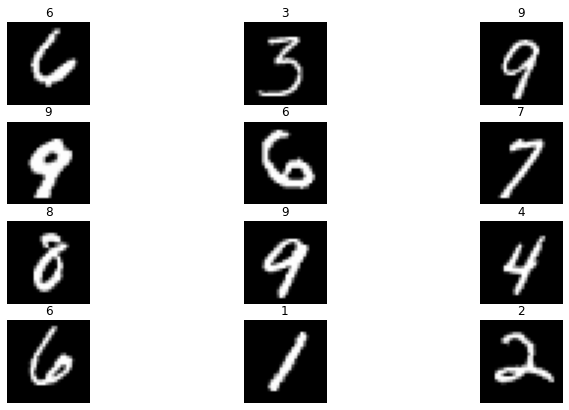

In [10]:
torch.manual_seed(42)

fig = plt.figure(figsize=(12, 7))
rows, cols = 4, 3

for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(X), size=[1]).item()
  img = data_transform(X[random_idx])
  label = y[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(label)
  plt.axis(False);

Above, images of 12 random handwritten digits are visualized after transformation.

Now, we are ready to prepare the DataLoader which helps turn a large dataset into a Python iterable of smaller mini-batches.

In [11]:
class DigitRecognizerTrainDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.dataset = train_df[:28000].to_numpy()

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        features, label = sample[1:], sample[0]
        features = features.reshape((28, 28, 1)).astype(np.uint8)
        
        transform = transforms.ToTensor()
        return transform(features), torch.tensor(label)

    def __len__(self):
        return len(self.dataset)

class DigitRecognizerTestDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.dataset = train_df[28000:].to_numpy()

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        features, label = sample[1:], sample[0]
        features = features.reshape((28, 28, 1)).astype(np.uint8)
        
        transform = transforms.ToTensor()
        return transform(features), torch.tensor(label)

    def __len__(self):
        return len(self.dataset)

In [12]:
train_set = DigitRecognizerTrainDataset()
test_set = DigitRecognizerTestDataset()

In [13]:
# set up batch size
batch_size = 32

# turn datasets into batches
train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             shuffle=False)

print(f"There are {len(train_dataloader)} batches of size {batch_size} in train dataloader.")
print(f"There are {len(test_dataloader)} batches of size {batch_size} in test dataloader.")

There are 875 batches of size 32 in train dataloader.
There are 438 batches of size 32 in test dataloader.


In [14]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# 4. Modeling

Now that the training and test data loaders are ready, we start building the model by subclassing `nn.Module` (the base class for all neural network modules).

In [15]:
class DigitRecognizerModel(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        # compresses the dimensions of a tensor into a single vector.
        # [C, H, W] -> [C, H*W]
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

Let's instantiate a model with `DigitRecognizerModel`. But we need to set the following parameters.

- `input_shape` represents the number of features we provide to the model. In this example, we set `input_shape` to 784 (= 28 pixels in height $\times$ 28 pixels in width).

- `hidden_units` indicates the number of neurons in the hidden layer(s). It is usually set to a value between 10 and 512. It's possible to try several values in this range to see at which value the model performs best on the test data. Here, we will set it to 100.

- `output_shape`, in this example, is equal to 10 because we have 10 digits (from 0 to 9).

We could add more hidden layers to create more complex models, and `hidden_units` can be different for each hidden layer.

Let's create an instance of `DigitRecognizerModel`.

In [16]:
torch.manual_seed(42)

model = DigitRecognizerModel(input_shape=28*28,
                             hidden_units=100,
                             output_shape=len(np.unique(y)))
model.to('cpu')

DigitRecognizerModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=10, bias=True)
    (4): ReLU()
  )
)

Before training the model, we need to set up the appropriate loss, optimization, and evaluation metrics since we are dealing with a multi-classification problem.

For evaluation, we use `torchmetrics.Accuracy`, which computes the fraction of correct predictions by the model. If predictions are floating points, it applies `torch.argmax` along the label classes to automatically convert probabilities/logits into an int tensor.

For the loss function, the cross-entropy loss does the work and the Stochastic Gradient Descent (SGD) algorithm is used as the optimizer.

Source - [Cross-Entropy Loss](https://www.youtube.com/watch?v=6ArSys5qHAU), [SGD](https://www.youtube.com/watch?v=vMh0zPT0tLI)

In [17]:
# set up accuracy function, loss function and optimizer
acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

We are now ready to train the model! 

In [18]:
# set the seed
torch.manual_seed(42)

# set the number of epochs
epochs = 5

# create training and testing loop
for epoch in range(epochs):
  print(f"Epoch: {epoch}\n------")
  
  # training
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model.train()
    # forward pass
    y_pred = model(X)
    # compute loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    # optimizer zero grad
    optimizer.zero_grad()
    # loss backward
    loss.backward()
    # optimizer step
    optimizer.step()

  train_loss /= len(train_dataloader)

  # testing
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      # forward pass
      test_pred = model(X)
      # compute loss
      test_loss += loss_fn(test_pred, y)
      # compute accuracy
      test_acc += acc_fn(test_pred, y)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")

Epoch: 0
------
Train loss: 0.8263 | Test loss: 0.5366, Test acc: 0.81%

Epoch: 1
------
Train loss: 0.4029 | Test loss: 0.2095, Test acc: 0.94%

Epoch: 2
------
Train loss: 0.1874 | Test loss: 0.1793, Test acc: 0.95%

Epoch: 3
------
Train loss: 0.1467 | Test loss: 0.1491, Test acc: 0.96%

Epoch: 4
------
Train loss: 0.1201 | Test loss: 0.1277, Test acc: 0.96%



We see that our model did very well on the test data after 5 epochs.

# 5. Making Predictions on the Data for Submission

The final step is to make predictions on the test dataset and submit our predictions to see how accurate they are.

In [19]:
class DigitRecognizerSubmissionDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.dataset = test_df.to_numpy()

    def __getitem__(self, idx):
        features = self.dataset[idx]
        features = features.reshape((28, 28, 1)).astype(np.uint8)
        
        transform = transforms.ToTensor()
        return transform(features)

    def __len__(self):
        return len(self.dataset)

In [20]:
submission_set = DigitRecognizerSubmissionDataset()

In [21]:
submission_dataloader = DataLoader(submission_set,
                                   batch_size=len(submission_set),
                                   shuffle=False)

In [22]:
model.eval()
with torch.inference_mode():
  for X in submission_dataloader:
    label_logits = model(X)

In [23]:
label_probs = torch.softmax(label_logits, dim=1)
Label = torch.argmax(label_probs, dim=1)

In [24]:
submission = pd.DataFrame(data=Label.numpy(), index=range(1, 28001),columns=['Label'])
submission.index.name = 'ImageId'

In [25]:
submission.head()

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3


In [26]:
submission.to_csv('submission_digit_recognizer.csv')